# Stock value prediction

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py

# Download data and normalize it

In [2]:
def get_stock_data(stock_name, normalize=True):
    start = datetime.datetime(2000, 1, 1)
    end = datetime.date.today()
    df = web.DataReader(stock_name, "yahoo", start, end)
    df.drop(['Volume', 'Close'], 1, inplace=True)
    
    if normalize:        
        min_max_scaler = preprocessing.MinMaxScaler()
        df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
        df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
        df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
        df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
    return df

Loading Google from yahoo finance

In [3]:
stock_name = '^GSPC'
df = get_stock_data(stock_name, normalize=True)
df.head()

,Open,High,Low,Adj Close
Date,,,,
2000-01-03,0.460498,0.458888,0.450320,0.452877
2000-01-04,0.452319,0.445533,0.426432,0.420424
2000-01-05,0.419792,0.420939,0.414905,0.421989
2000-01-06,0.421360,0.420136,0.423321,0.422768
2000-01-07,0.422141,0.437472,0.428358,0.444880


Saving the data to a file for a future use

In [4]:
#today = datetime.date.today()
#file_name = stock_name+'_stock_%s.csv' % today
#df.to_csv(file_name)

# Plot out the Normalized Adjusted close price

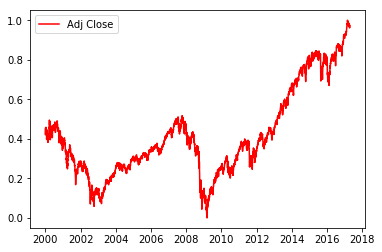

In [5]:
plt.plot(df['Adj Close'], color='red', label='Adj Close')
plt.legend(loc='best')
plt.show()

# Set last day Adjusted Close as y

In [6]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features # (3893, 23, 4)
    x_train = train[:, :-1] # x = all feature except adj close # (3893, 22, 4)
    y_train = train[:, -1][:,-1] # y = last feature, last day (3893)
    x_test = result[int(row):, :-1] #(432, 22, 4)
    y_test = result[int(row):, -1][:,-1] #(432)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

# Buidling neural network

In [24]:
# 4, 22, 1
def build_model(layers):
    model = Sequential()

    model.add(LSTM(units=360, input_shape=(layers[1],layers[0]), return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=120, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(0.2))

    #model.add(Dense(32,kernel_initializer="uniform",activation='relu'))  
    model.add(Dense(layers[2], activation='linear'))

    start = time.time()
    #adam = keras.optimizers.Adam(lr=1, decay=0.2)
    model.compile(loss="mse", optimizer="adam",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    # adam = keras.optimizers.Adam(decay=0.2)
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

# Setting X and Y for training and testing

In [25]:
window = 22
X_train, y_train, X_test, y_test = load_data(df, window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (3893, 22, 4)
y_train (3893,)
X_test (433, 22, 4)
y_test (433,)


# Compile model
amount of feature, day of data, output

In [26]:
model = build_model2([4,window,1])

Compilation Time :  0.029074668884277344


# Executing the model & RMS/RMSE results

In [27]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=300,
    validation_split=0.1,
    verbose=1)

Train on 3503 samples, validate on 390 samples
Epoch 1/300
3503/3503 [==============================] - 1s - loss: 0.1063 - acc: 2.8547e-04 - val_loss: 0.3417 - val_acc: 0.0000e+00
Epoch 2/300
3503/3503 [==============================] - 0s - loss: 0.0271 - acc: 2.8547e-04 - val_loss: 0.0966 - val_acc: 0.0000e+00
Epoch 3/300
3503/3503 [==============================] - 0s - loss: 0.0135 - acc: 2.8547e-04 - val_loss: 0.2255 - val_acc: 0.0000e+00
Epoch 4/300
3503/3503 [==============================] - 0s - loss: 0.0132 - acc: 2.8547e-04 - val_loss: 0.1429 - val_acc: 0.0000e+00
Epoch 5/300
3503/3503 [==============================] - 0s - loss: 0.0092 - acc: 2.8547e-04 - val_loss: 0.1131 - val_acc: 0.0000e+00
Epoch 6/300
3503/3503 [==============================] - ETA: 0s - loss: 0.0052 - acc: 3.2552e-0 - 0s - loss: 0.0050 - acc: 2.8547e-04 - val_loss: 0.0664 - val_acc: 0.0000e+00
Epoch 7/300
3503/3503 [==============================] - 0s - loss: 0.0020 - acc: 2.8547e-04 - val_loss: 0.

3503/3503 [==============================] - 0s - loss: 5.3568e-04 - acc: 2.8547e-04 - val_loss: 3.6522e-04 - val_acc: 0.0000e+00
Epoch 60/300
3503/3503 [==============================] - 0s - loss: 5.5991e-04 - acc: 2.8547e-04 - val_loss: 3.1734e-04 - val_acc: 0.0000e+00
Epoch 61/300
3503/3503 [==============================] - 0s - loss: 5.1617e-04 - acc: 2.8547e-04 - val_loss: 3.9557e-04 - val_acc: 0.0000e+00
Epoch 62/300
3503/3503 [==============================] - 0s - loss: 5.1612e-04 - acc: 2.8547e-04 - val_loss: 3.1015e-04 - val_acc: 0.0000e+00
Epoch 63/300
3503/3503 [==============================] - 0s - loss: 5.0339e-04 - acc: 2.8547e-04 - val_loss: 3.6115e-04 - val_acc: 0.0000e+00
Epoch 64/300
3503/3503 [==============================] - 0s - loss: 5.3499e-04 - acc: 2.8547e-04 - val_loss: 3.1006e-04 - val_acc: 0.0000e+00
Epoch 65/300
3503/3503 [==============================] - 0s - loss: 5.1257e-04 - acc: 2.8547e-04 - val_loss: 3.0109e-04 - val_acc: 0.0000e+00
Epoch 66/300

3503/3503 [==============================] - 0s - loss: 4.3620e-04 - acc: 2.8547e-04 - val_loss: 3.5923e-04 - val_acc: 0.0000e+00
Epoch 117/300
3503/3503 [==============================] - 0s - loss: 4.3679e-04 - acc: 2.8547e-04 - val_loss: 2.3922e-04 - val_acc: 0.0000e+00
Epoch 118/300
3503/3503 [==============================] - 0s - loss: 4.3562e-04 - acc: 2.8547e-04 - val_loss: 5.3297e-04 - val_acc: 0.0000e+00
Epoch 119/300
3503/3503 [==============================] - 0s - loss: 4.5447e-04 - acc: 2.8547e-04 - val_loss: 2.6241e-04 - val_acc: 0.0000e+00
Epoch 120/300
3503/3503 [==============================] - 0s - loss: 4.4328e-04 - acc: 2.8547e-04 - val_loss: 2.4091e-04 - val_acc: 0.0000e+00
Epoch 121/300
3503/3503 [==============================] - 0s - loss: 4.1267e-04 - acc: 2.8547e-04 - val_loss: 4.5189e-04 - val_acc: 0.0000e+00
Epoch 122/300
3503/3503 [==============================] - 0s - loss: 4.4299e-04 - acc: 2.8547e-04 - val_loss: 2.2952e-04 - val_acc: 0.0000e+00
Epoch 

3503/3503 [==============================] - 0s - loss: 3.5527e-04 - acc: 2.8547e-04 - val_loss: 1.8214e-04 - val_acc: 0.0000e+00
Epoch 173/300
3503/3503 [==============================] - 0s - loss: 3.4020e-04 - acc: 2.8547e-04 - val_loss: 1.7621e-04 - val_acc: 0.0000e+00
Epoch 174/300
3503/3503 [==============================] - 0s - loss: 3.7518e-04 - acc: 2.8547e-04 - val_loss: 2.1282e-04 - val_acc: 0.0000e+00
Epoch 175/300
3503/3503 [==============================] - 0s - loss: 4.0309e-04 - acc: 2.8547e-04 - val_loss: 2.0048e-04 - val_acc: 0.0000e+00
Epoch 176/300
3503/3503 [==============================] - 0s - loss: 4.0253e-04 - acc: 2.8547e-04 - val_loss: 2.5620e-04 - val_acc: 0.0000e+00
Epoch 177/300
3503/3503 [==============================] - 0s - loss: 3.7034e-04 - acc: 2.8547e-04 - val_loss: 1.7619e-04 - val_acc: 0.0000e+00
Epoch 178/300
3503/3503 [==============================] - 0s - loss: 3.5164e-04 - acc: 2.8547e-04 - val_loss: 1.7578e-04 - val_acc: 0.0000e+00
Epoch 

3503/3503 [==============================] - 0s - loss: 2.9086e-04 - acc: 2.8547e-04 - val_loss: 1.8242e-04 - val_acc: 0.0000e+00
Epoch 229/300
3503/3503 [==============================] - 0s - loss: 3.0754e-04 - acc: 2.8547e-04 - val_loss: 1.6409e-04 - val_acc: 0.0000e+00
Epoch 230/300
3503/3503 [==============================] - 0s - loss: 3.0845e-04 - acc: 2.8547e-04 - val_loss: 1.7709e-04 - val_acc: 0.0000e+00
Epoch 231/300
3503/3503 [==============================] - 0s - loss: 2.9988e-04 - acc: 2.8547e-04 - val_loss: 2.5554e-04 - val_acc: 0.0000e+00
Epoch 232/300
3503/3503 [==============================] - 0s - loss: 2.9273e-04 - acc: 2.8547e-04 - val_loss: 1.6786e-04 - val_acc: 0.0000e+00
Epoch 233/300
3503/3503 [==============================] - 0s - loss: 2.9139e-04 - acc: 2.8547e-04 - val_loss: 1.6437e-04 - val_acc: 0.0000e+00
Epoch 234/300
3503/3503 [==============================] - 0s - loss: 2.8904e-04 - acc: 2.8547e-04 - val_loss: 2.4910e-04 - val_acc: 0.0000e+00
Epoch 

3503/3503 [==============================] - 0s - loss: 2.4710e-04 - acc: 2.8547e-04 - val_loss: 2.2273e-04 - val_acc: 0.0000e+00
Epoch 285/300
3503/3503 [==============================] - 0s - loss: 2.2982e-04 - acc: 2.8547e-04 - val_loss: 1.9382e-04 - val_acc: 0.0000e+00
Epoch 286/300
3503/3503 [==============================] - 0s - loss: 2.3637e-04 - acc: 2.8547e-04 - val_loss: 2.0150e-04 - val_acc: 0.0000e+00
Epoch 287/300
3503/3503 [==============================] - 0s - loss: 2.3441e-04 - acc: 2.8547e-04 - val_loss: 1.7399e-04 - val_acc: 0.0000e+00
Epoch 288/300
3503/3503 [==============================] - 0s - loss: 2.3749e-04 - acc: 2.8547e-04 - val_loss: 1.4822e-04 - val_acc: 0.0000e+00
Epoch 289/300
3503/3503 [==============================] - 0s - loss: 2.3385e-04 - acc: 2.8547e-04 - val_loss: 1.5664e-04 - val_acc: 0.0000e+00
Epoch 290/300
3503/3503 [==============================] - 0s - loss: 2.2924e-04 - acc: 2.8547e-04 - val_loss: 1.3712e-04 - val_acc: 0.0000e+00
Epoch 

To terminal
tensorboard --logdir=/Users/kachunfung/python/projects/logs

In [29]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00012 MSE (0.01 RMSE)
Test Score: 0.00018 MSE (0.01 RMSE)


# Test Result

1. 100epochs, LSTM128 > LSTM128 > 16relu > 1linear
Train Score: 0.00032 MSE (0.02 RMSE)
Test Score: 0.00046 MSE (0.02 RMSE)

2. 100epochs, LSTM80 > LSTM80 > 32relu > 1linear
Train Score: 0.00039 MSE (0.02 RMSE)
Test Score: 0.00258 MSE (0.05 RMSE)

3. 100epochs, LSTM128 > LSTM128 > 64relu > 1linear
Train Score: 0.00029 MSE (0.02 RMSE)
Test Score: 0.00060 MSE (0.02 RMSE)

4. 100epochs, LSTM128 > LSTM128 > 32relu > 1linear
Train Score: 0.00027 MSE (0.02 RMSE)
Test Score: 0.00077 MSE (0.03 RMSE)

5. 300epochs, LSTM128 > LSTM128 > 32relu > 1linear
Train Score: 0.00012 MSE (0.01 RMSE)
Test Score: 0.00018 MSE (0.01 RMSE)

# Prediction vs Real results

In [30]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
print (p.shape)
# for each data index in test data
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    # print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))
    # Last day prediction
    # print(p[-1]) 

(433, 1)


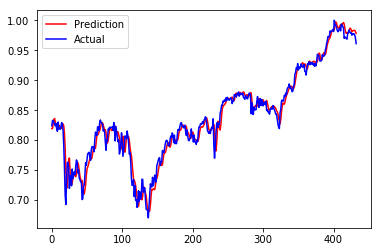

In [31]:
import matplotlib.pyplot as plt2

plt2.plot(p,color='red', label='Prediction')
plt2.plot(y_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()

# Denormalizing result

In [39]:
def denormalize(stock_name, normalized_value):
    start = datetime.datetime(2000, 1, 1)
    end = datetime.date.today()
    df = web.DataReader(stock_name, "yahoo", start, end)
    
    df = df['Adj Close'][-432:].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(stock_name, p)
newy_test = denormalize(stock_name, y_test)

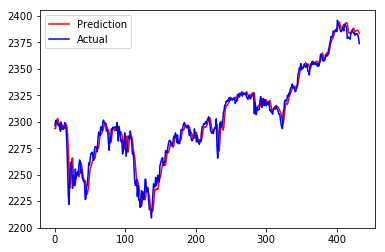

In [42]:
import matplotlib.pyplot as plt2

plt2.plot(newp, color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()

# Save for consistency

In [41]:
model.save('LSTM_Stock_prediction-20170418.h5')

ImportError: `save_model` requires h5py.

In [44]:
print (len(p)) # Notice that it is 433 business day.

433
